In [5]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import geopandas as gpd

In [6]:
elects = pd.read_csv("../data/TX_statewide_18_Dem_Runofff.csv").drop(columns=["Unnamed: 0"])
tx_prec_shapes = gpd.read_file("../data/TX_VTDs_cvap/TX_VTDs_cvap.shp")
dallas_county_pcts = pd.merge(left=tx_prec_shapes, right=elects, on="CNTYVTD").query("CNTY == 113")

In [7]:
dallas_runs_noised = pd.read_csv("dallas_pcts/toydown_dallas_county_prec_runs.csv")

In [8]:
dallas_county_pcts = pd.merge(left=dallas_county_pcts, right=dallas_runs_noised, on="CNTYVTD")

In [18]:
def plot_er_graph(data, cand, race, elect, tot_vote, eps, split,
                  filt=True, n_samps=32, ax=None, title=True, plot_cvap=False):
    
    df = data.query("epsilon == @eps & split == @split")
    df = df.query("`{}` > 10".format(tot_vote)) if filt else df
    xp = np.linspace(0, 1, 100)
    perc_race = df["{}_pct".format(race)].fillna(0) #(df.HVAP10 / df.VAP10).fillna(0)
    perc_cand = df["{}D_18R_Governor_pct".format(cand)].fillna(0) #(df[cand_col] / sum([df[c] for c in elect_cols])).fillna(0)
    line = sp.stats.linregress(perc_race, perc_cand)
    l = np.poly1d([line.slope, line.intercept])

    ms = np.zeros(n_samps)

    if ax==None:
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(1, 1, 1)
    if title: ax.set_title("ER - Votes for {}: {}".format(cand, elect))
    ax.set_xlim(-0.05,1.05)
    ax.set_ylim(-0.05,1.05)

    for i in range(n_samps):
        perc_race_noised = (df["{}_{}_noise".format(i, race)] / df["{}_VAP_noise".format(i)]).fillna(0)
            
        line_noised = sp.stats.linregress(perc_race_noised, perc_cand)
        ln = np.poly1d([line_noised.slope, line_noised.intercept])
        ms[i] = line_noised.slope
        ax.plot(perc_race_noised, perc_cand, '.', color="lightcoral")
        ax.plot(xp, ln(xp), '-', color="red")
    
    ax.plot(perc_race, perc_cand, '.', color="b")
    ax.plot(xp, l(xp), '-', color="b", 
             label="m: {}".format(round(line.slope, 3)))
    ax.plot([], [], '-', color="r", 
             label="E(m): {}, Var(m): {}".format(round(np.mean(ms),3), round(np.var(ms),4)))  
    
    ax.legend()
    ax.set_xlabel("% {}".format(race))
    ax.set_ylabel("{} % of Voters".format(cand))
    return ax

In [19]:
def plot_elect_grid(epsilon_values, epsilon_splits, data, candidate, race, election, 
                    tot_vote, figsize=(10,10), filt=True, title=True):
    
    fig, axs = plt.subplots(len(epsilon_values),len(epsilon_splits), figsize=figsize)

    if title: fig.suptitle("ER - Votes for {}: {}".format(candidate, election))
    plt.subplots_adjust(hspace = 0.25)

    for i in range(len(epsilon_values)):
        for j in range(len(epsilon_splits)):
            plot_er_graph(data, candidate, race, election, tot_vote, 
                          epsilon_values[i], epsilon_splits[j], 
                          title=False, ax=axs[i,j], filt=filt)

    pad = 5
    for ax, row in zip(axs[:,0], ["$\epsilon$ = {}".format(eps) for eps in epsilon_values]):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center')

    for ax, col in zip(axs[0], ["Split: {}".format(s) for s in epsilon_splits]):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, ax.xaxis.labelpad + pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')
        
    return fig, axs

In [39]:
def plot_point_estimates(data, cand, race, elect, tot_vote, eps, split,
                         filt=True, n_samps=32, ax=None, title=True, x_lims=None):
    
    df = data.query("epsilon == @eps & split == @split")
    df = df.query("`{}` > 10".format(tot_vote)) if filt else df
    perc_race = df["{}_pct".format(race)].fillna(0) #(df.HVAP10 / df.VAP10).fillna(0)
    perc_cand = df["{}D_18R_Governor_pct".format(cand)].fillna(0) #(df[cand_col] / sum([df[c] for c in elect_cols])).fillna(0)
    line = sp.stats.linregress(perc_race, perc_cand)
    l = np.poly1d([line.slope, line.intercept])

    ms = np.zeros(n_samps)
    zeros = np.zeros(n_samps)
    ones = np.zeros(n_samps)

    if ax==None:
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(1, 1, 1)
    if title: ax.set_title("ER Point Estimates - Votes for {}: {}".format(cand, elect))

    if x_lims: ax.set_xlim(x_lims[0],x_lims[1])

    for i in range(n_samps):
        perc_race_noised = (df["{}_{}_noise".format(i, race)] / df["{}_VAP_noise".format(i)]).fillna(0)
            
        line_noised = sp.stats.linregress(perc_race_noised, perc_cand)
        ln = np.poly1d([line_noised.slope, line_noised.intercept])
        ms[i] = line_noised.slope
        zeros[i] = line_noised.intercept
        ones[i] = ln(1)
    
    ax.hist(zeros, color="limegreen", alpha=0.5, label="all but {} support".format(race))
    ax.hist(ones, color="mediumpurple",  alpha=0.5, label="{} support".format(race))
    ax.axvline(zeros.mean(), color="limegreen")
    ax.axvline(ones.mean(), color="mediumpurple")
    ax.axvline(l(0), color="slategrey", linestyle="dashed")
    ax.axvline(l(1), color="slategrey", linestyle="dashed", label="un-noised data")
    
    ax.legend(loc="upper center")
    ax.set_xlabel("support for {}".format(cand))
    return ax

In [40]:
def plot_point_estimate_grid(epsilon_values, epsilon_splits, data, candidate, race, election, 
                    tot_vote, figsize=(10,10), filt=True, title=True, x_lims=None):
    
    fig, axs = plt.subplots(len(epsilon_values),len(epsilon_splits), figsize=figsize)

    if title: fig.suptitle("ER - Votes for {}: {}".format(candidate, election))
    plt.subplots_adjust(hspace = 0.25)

    for i in range(len(epsilon_values)):
        for j in range(len(epsilon_splits)):
            plot_point_estimates(data, candidate, race, election, tot_vote, 
                                 epsilon_values[i], epsilon_splits[j], 
                                 title=False, ax=axs[i,j], filt=filt, x_lims=x_lims)

    pad = 5
    for ax, row in zip(axs[:,0], ["$\epsilon$ = {}".format(eps) for eps in epsilon_values]):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center')

    for ax, col in zip(axs[0], ["Split: {}".format(s) for s in epsilon_splits]):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, ax.xaxis.labelpad + pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')
        
    return fig, axs

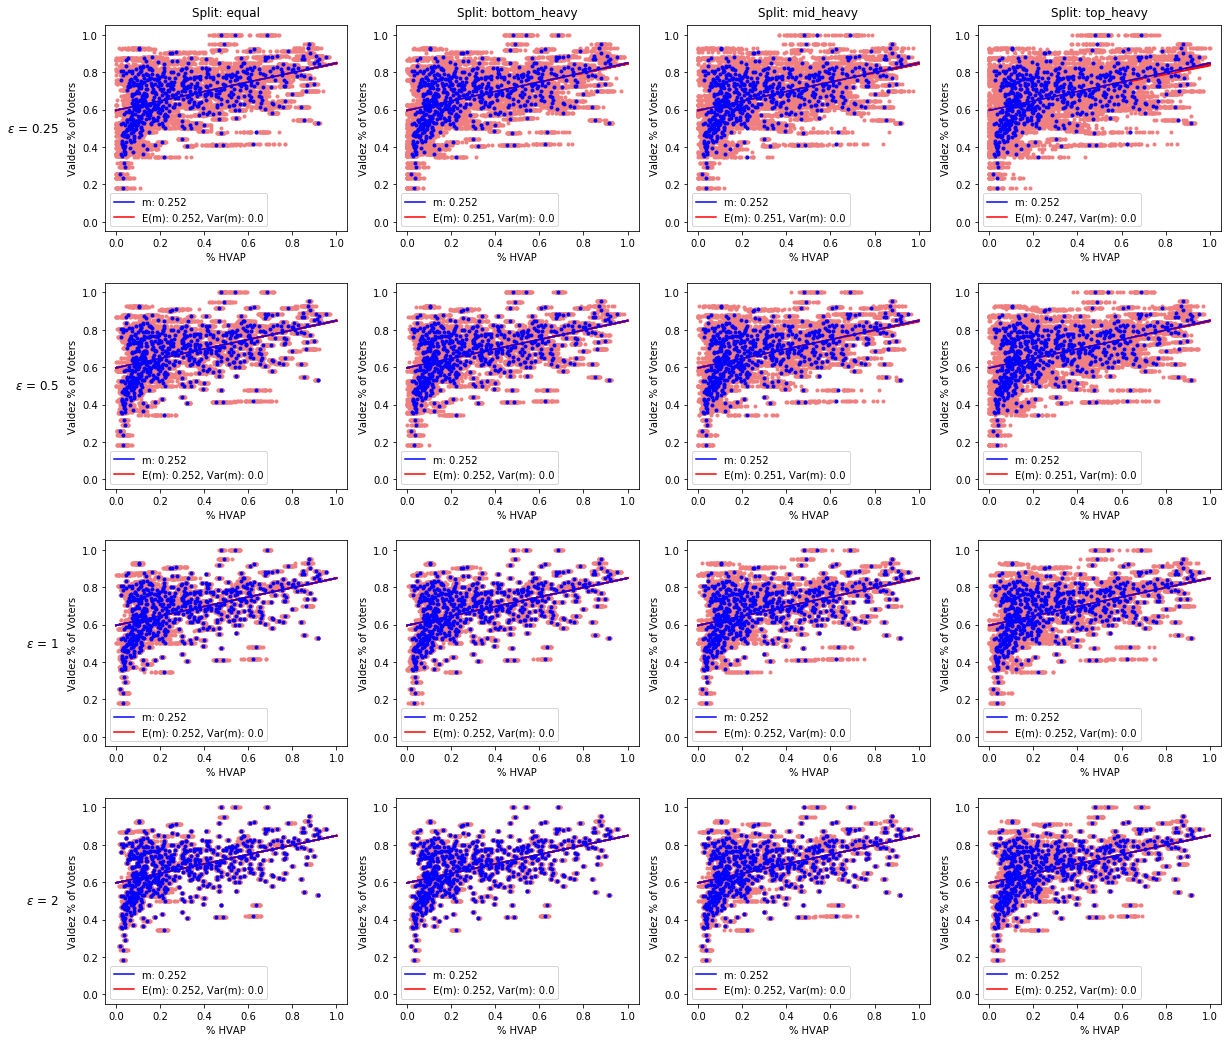

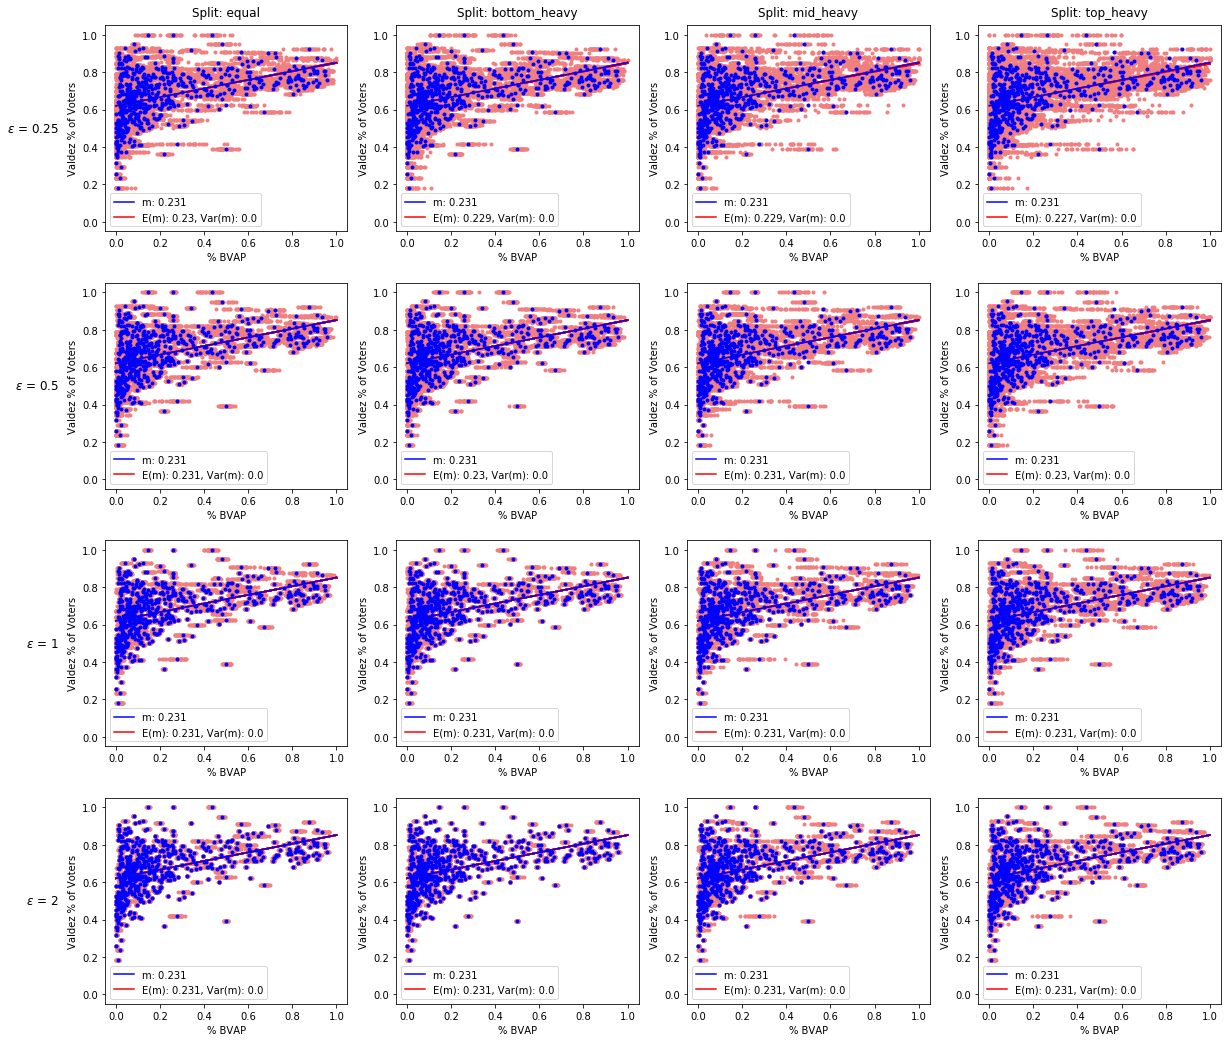

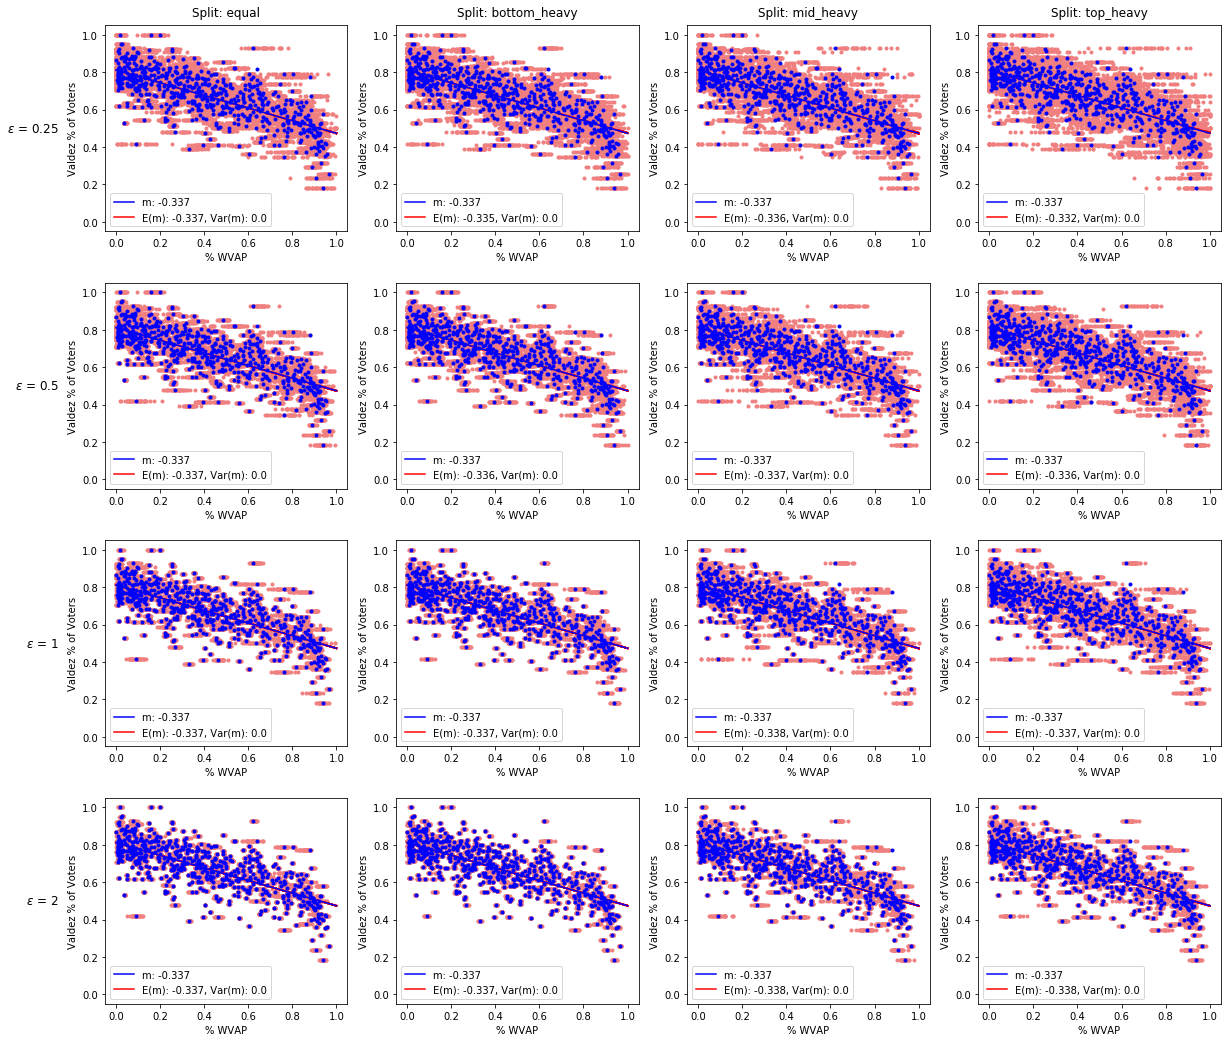

In [41]:
epsilon_values = [0.25, 0.5, 1, 2]
epsilon_splits = ["equal","bottom_heavy", "mid_heavy", "top_heavy",]
data = dallas_county_pcts
candidate = "Valdez"
election = "TX Statewide 2018 Dem Runofff Govenor"
tot_vote = "18R_Governor_D_tot"

for race in ["HVAP", "BVAP", "WVAP"]:
    fig, axs = plot_elect_grid(epsilon_values, epsilon_splits, data, candidate, race, election, 
                               tot_vote, figsize=(20,18), title=False)
    plt.savefig("plots/ER_{}_{}_{}_elect_param_grid.png".format(candidate, 
                                                                election.replace(',', "").replace(' ', '_'),
                                                                race),
                dpi=200, bbox_inches="tight")

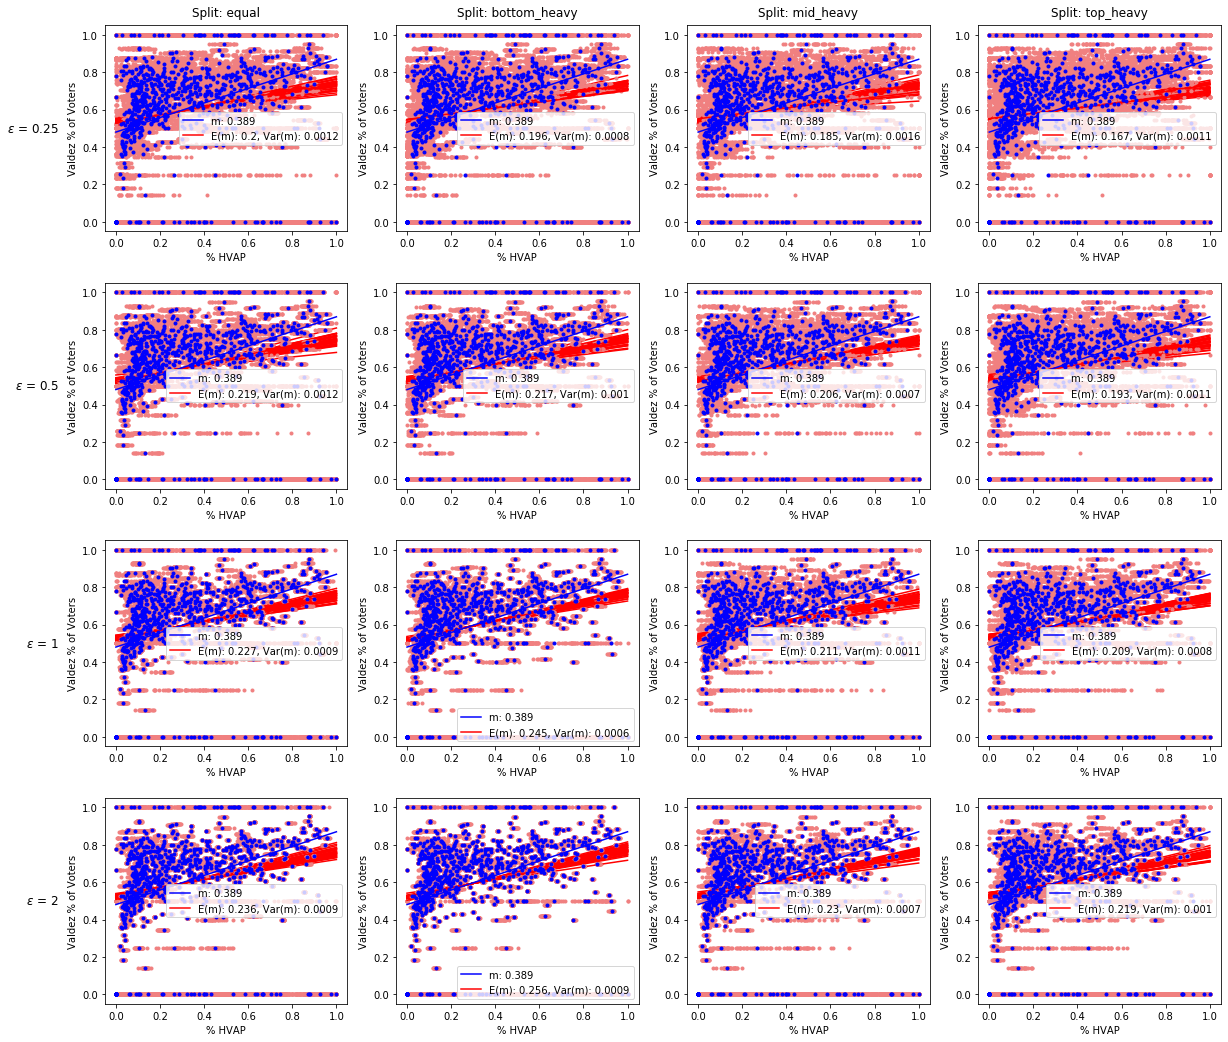

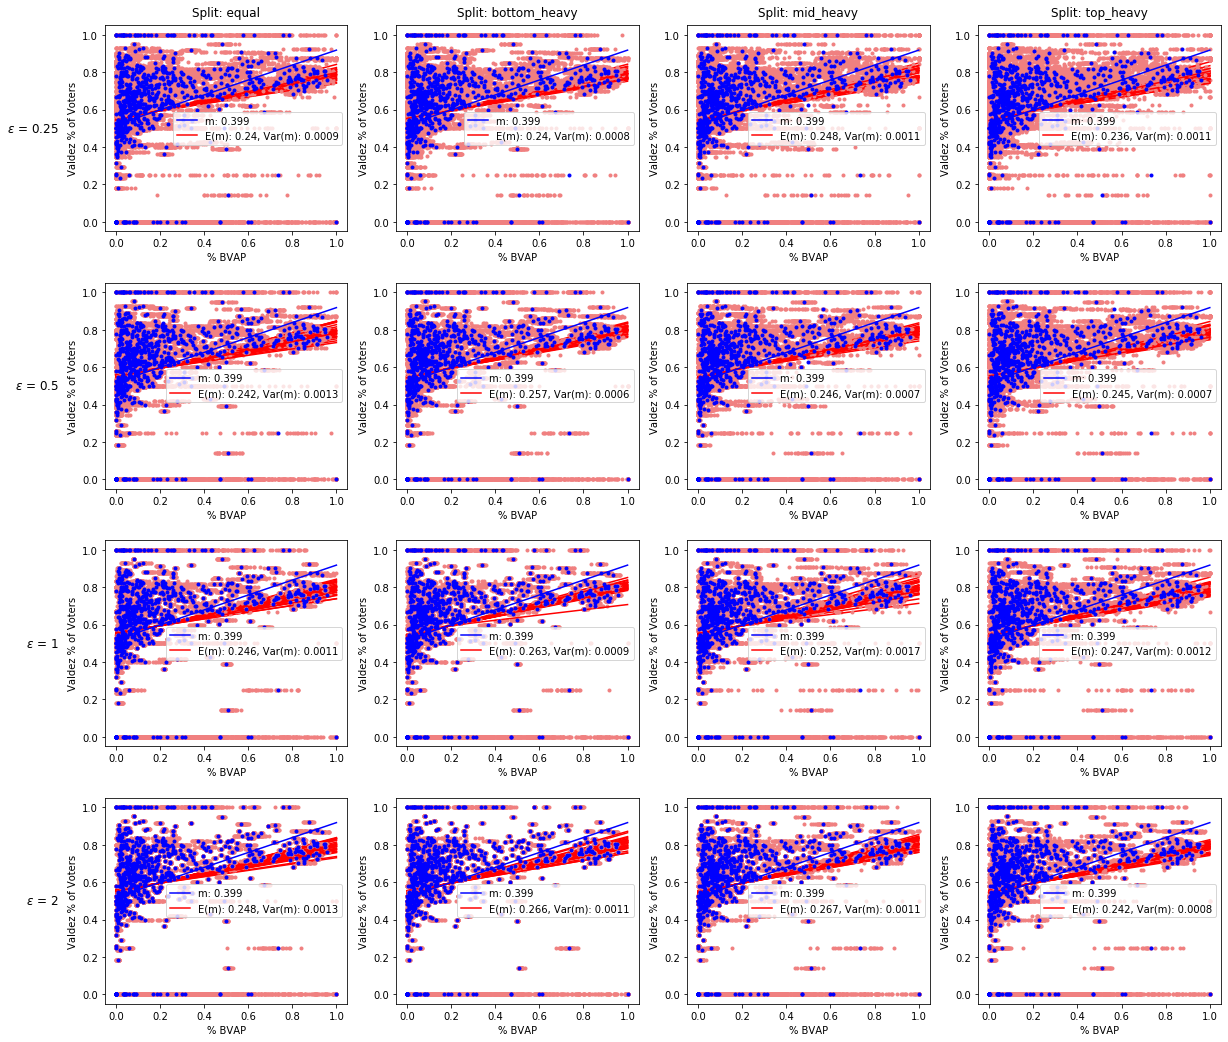

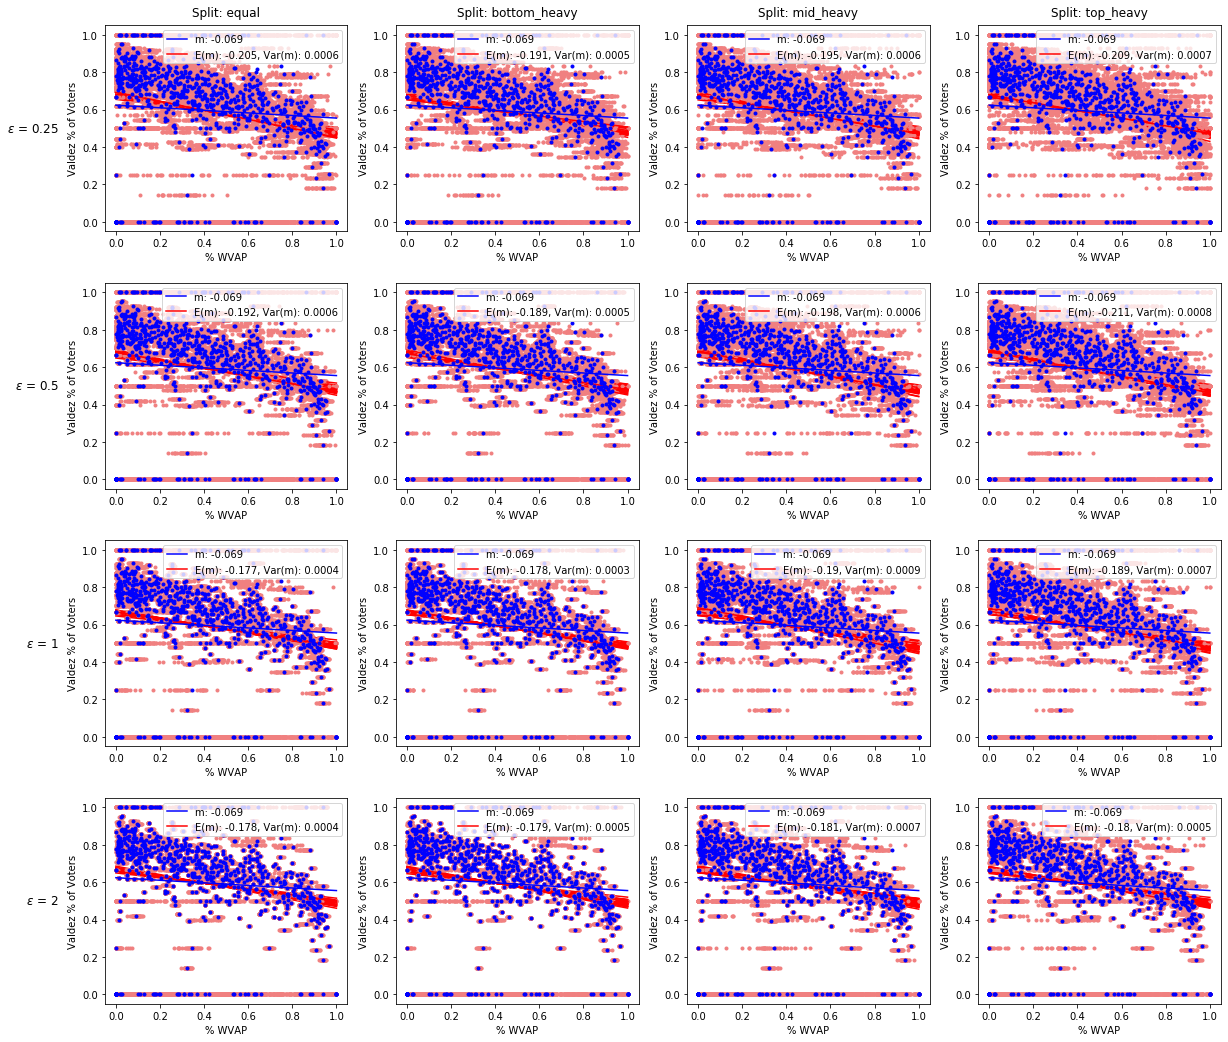

In [43]:
for race in ["HVAP", "BVAP", "WVAP"]:
    fig, axs = plot_elect_grid(epsilon_values, epsilon_splits, data, candidate, race, election, 
                               tot_vote, figsize=(20,18), title=False, filt=False)
    plt.savefig("plots/ER_{}_{}_{}_elect_param_grid_no_filt.png".format(candidate, 
                                                                election.replace(',', "").replace(' ', '_'),
                                                                race),
                dpi=200, bbox_inches="tight")

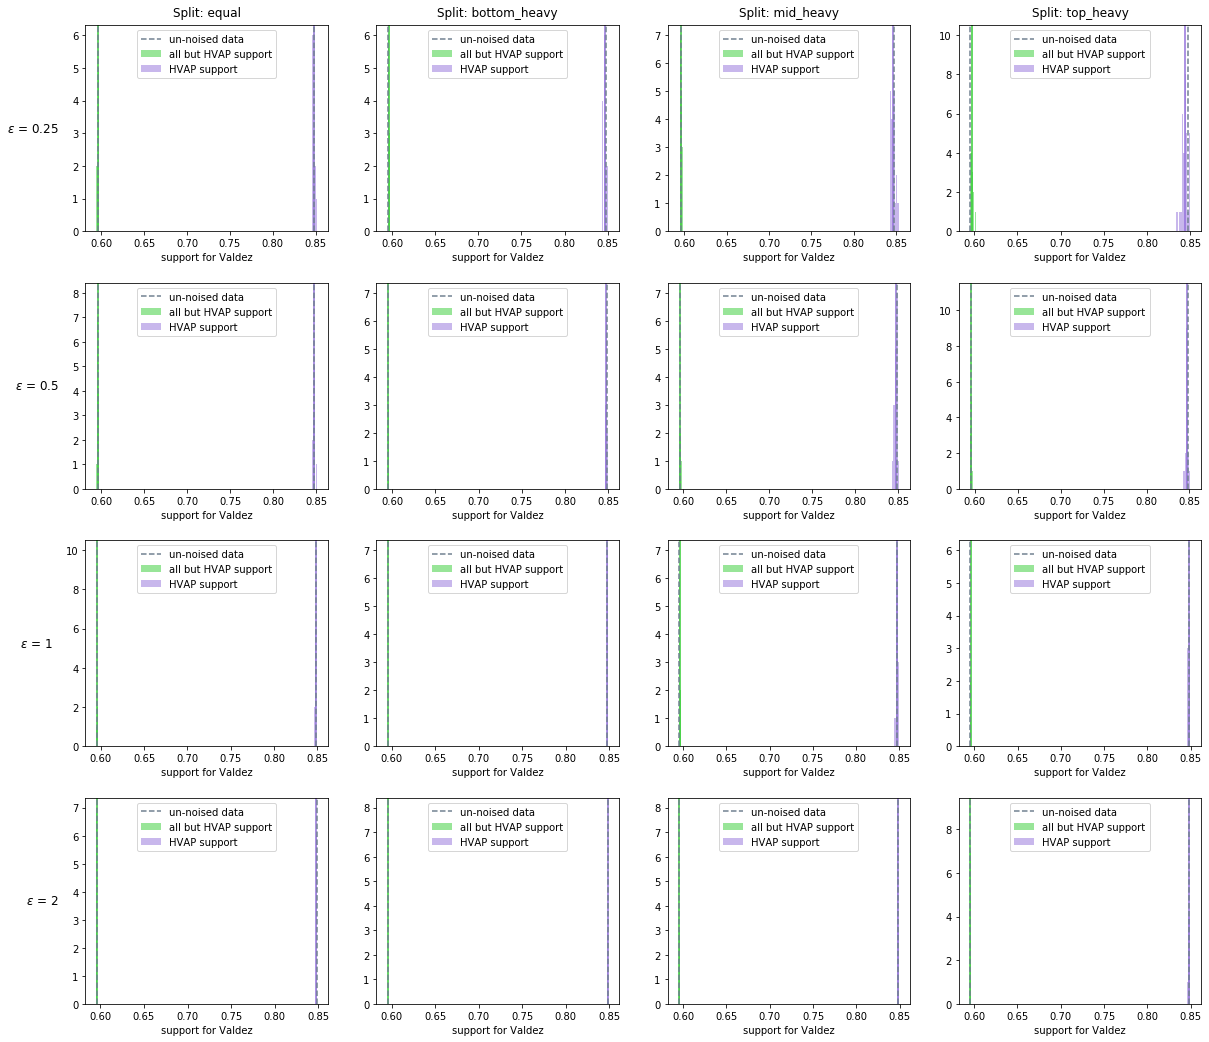

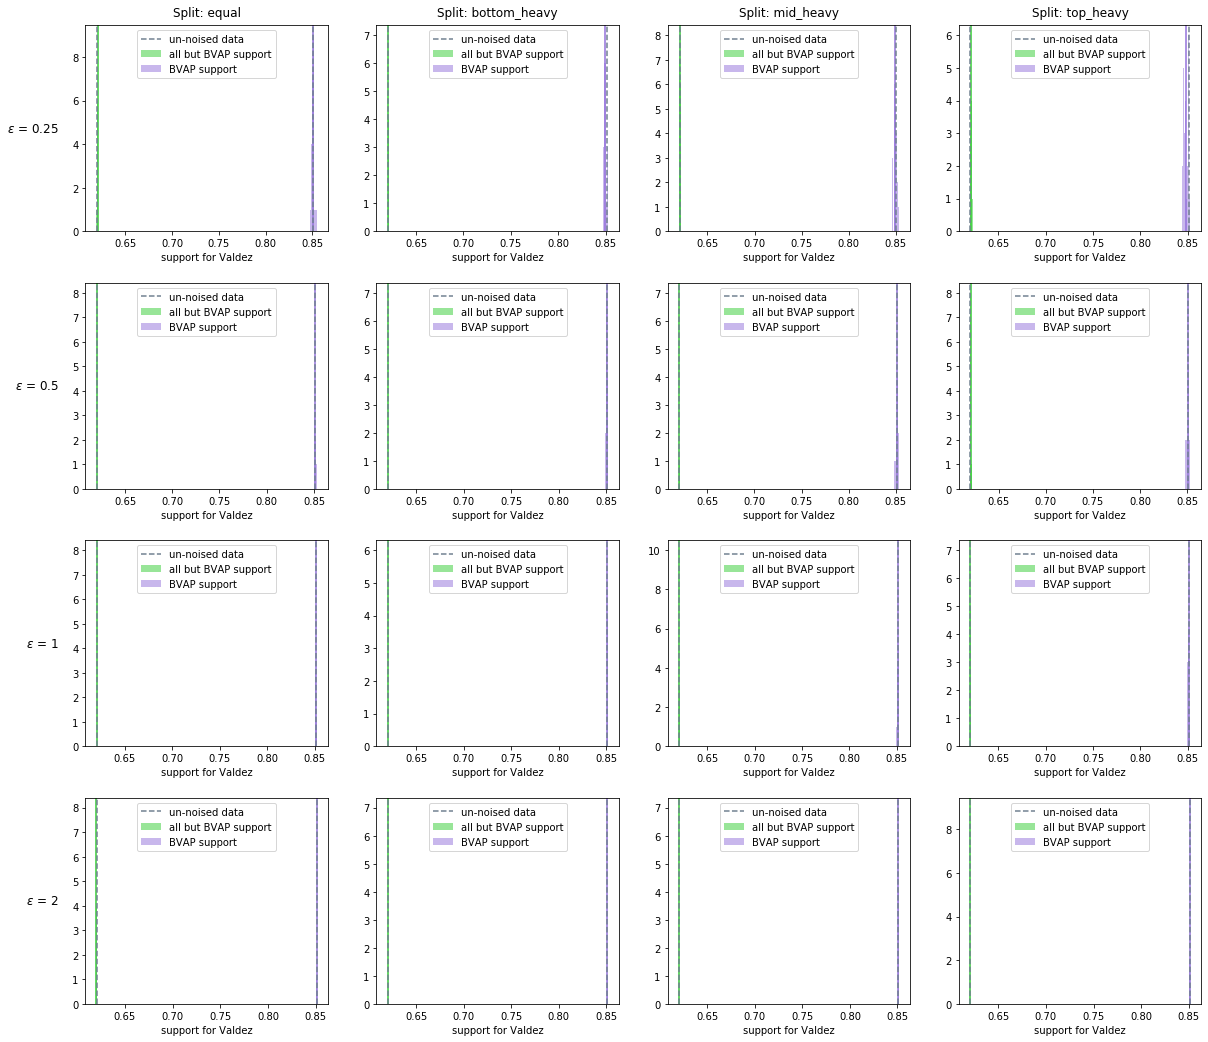

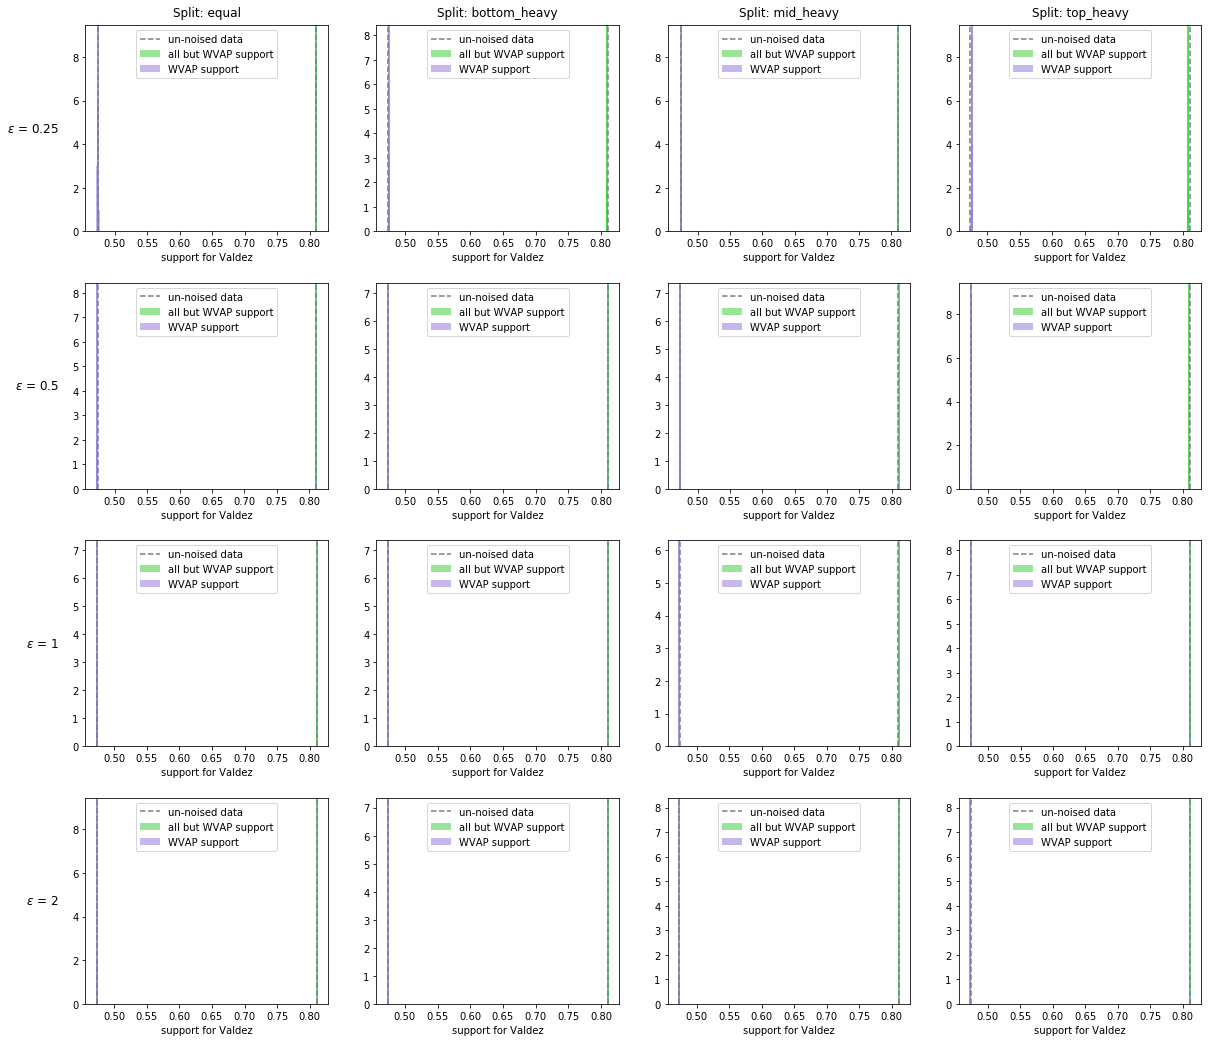

In [44]:
for race in ["HVAP", "BVAP", "WVAP"]:
    fig, axs = plot_point_estimate_grid(epsilon_values, epsilon_splits, data, candidate, race, election, 
                                           tot_vote, figsize=(20,18), title=False)
    plt.savefig("plots/ER_{}_{}_{}_elect_param_grid_points.png".format(candidate, 
                                                                election.replace(',', "").replace(' ', '_'),
                                                                race),
                dpi=200, bbox_inches="tight")

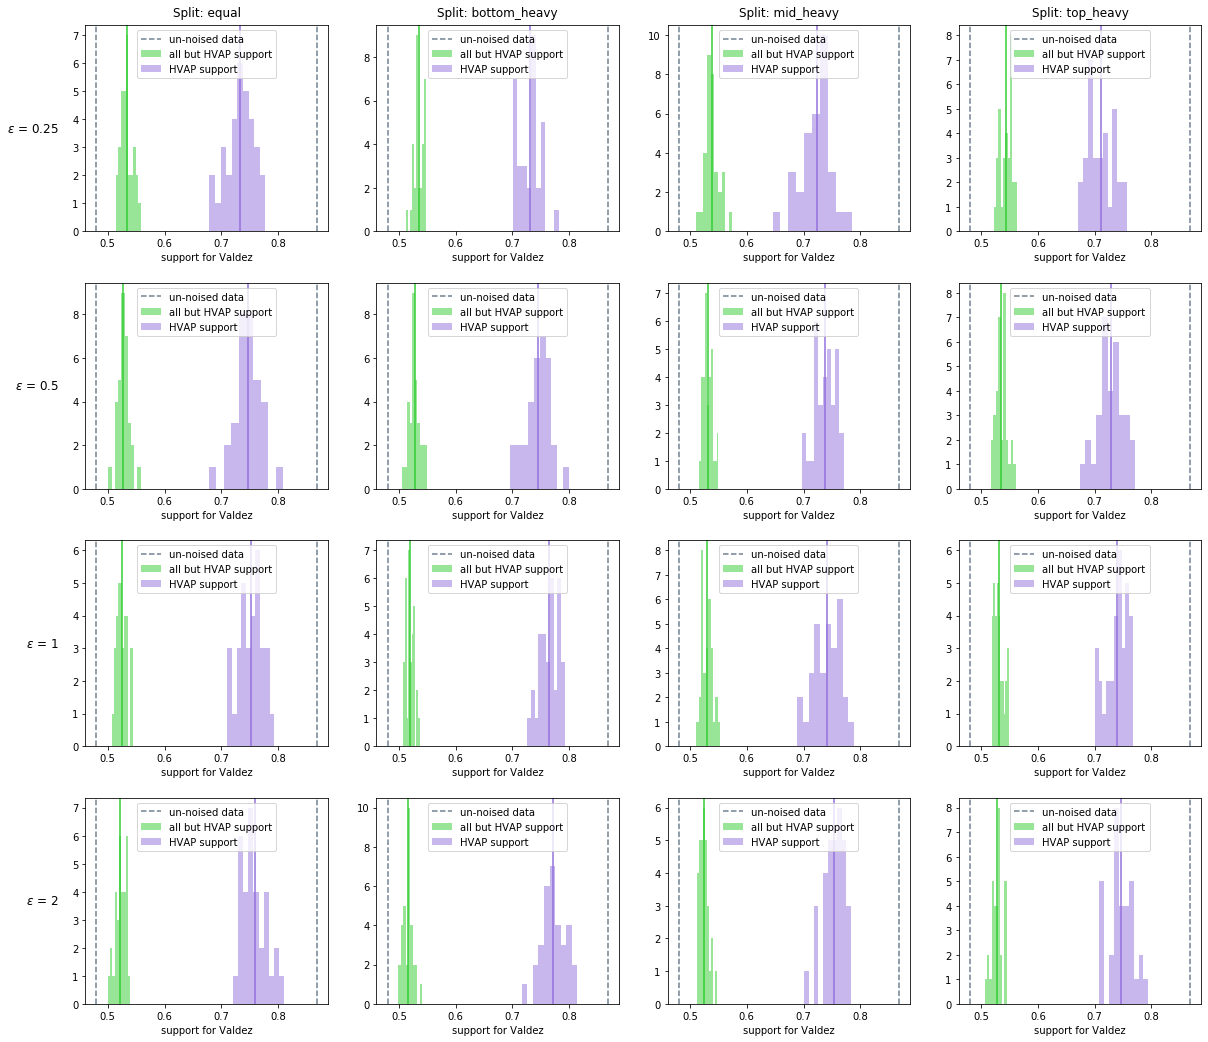

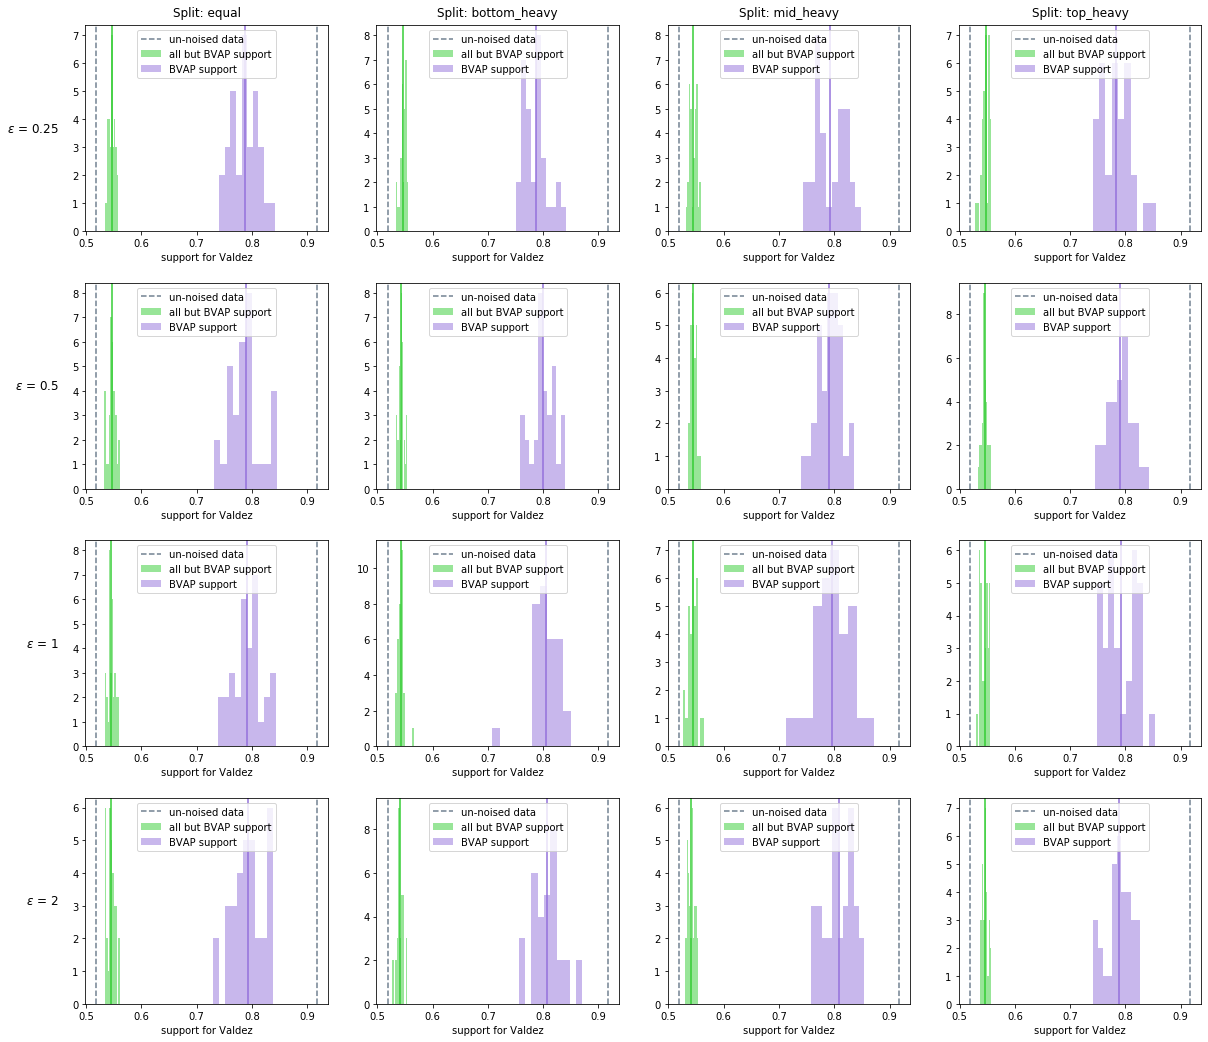

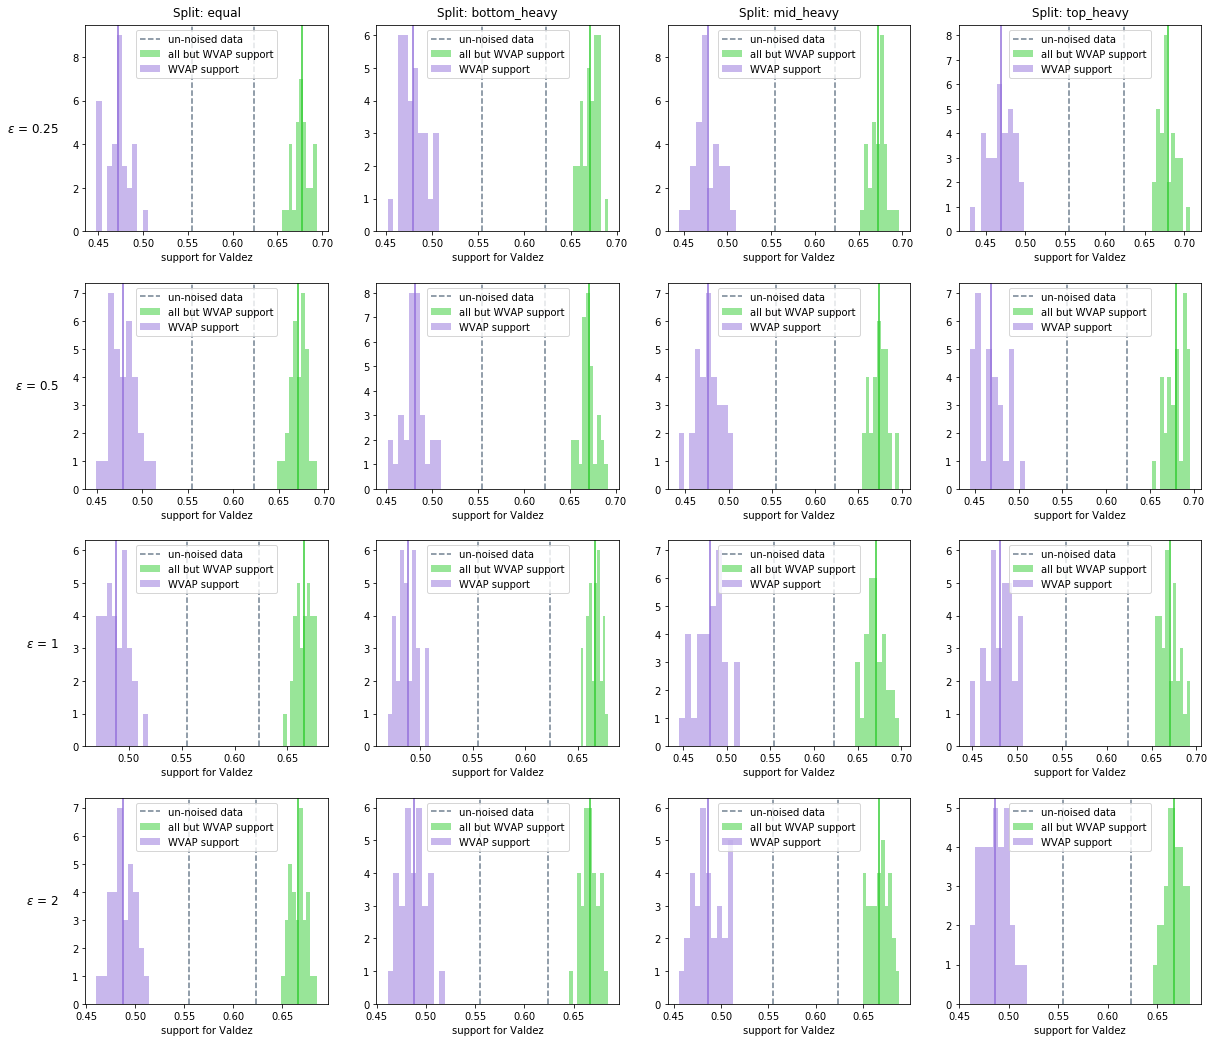

In [45]:
for race in ["HVAP", "BVAP", "WVAP"]:
    fig, axs = plot_point_estimate_grid(epsilon_values, epsilon_splits, data, candidate, race, election, 
                               tot_vote, figsize=(20,18), title=False, filt=False)
    plt.savefig("plots/ER_{}_{}_{}_elect_param_grid_points_no_filt.png".format(candidate, 
                                                                election.replace(',', "").replace(' ', '_'),
                                                                race),
                dpi=200, bbox_inches="tight")

In [ ]:
dallas_county_pcts.query("epsilon == 1 & split == 'equal'")

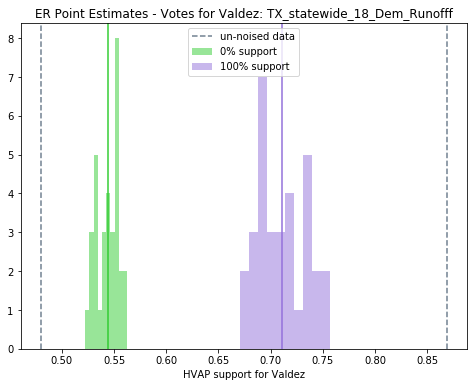

In [34]:
plot_point_estimates(dallas_county_pcts, "Valdez", "HVAP", "TX_statewide_18_Dem_Runofff",
                          "18R_Governor_D_tot", 0.25, "top_heavy", filt=False)
plt.show()

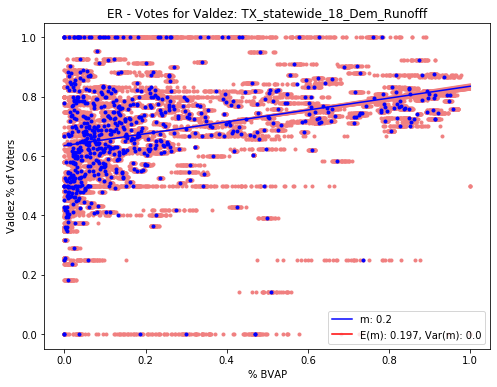

In [94]:
plot_er_graph(dallas_county_pcts, "Valdez", "BVAP", "TX_statewide_18_Dem_Runofff",
              "18R_Governor_D_tot", 2, "top_heavy")
plt.show()

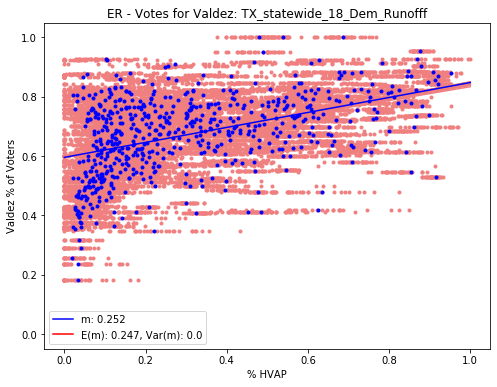

In [85]:
plot_er_graph(dallas_county_pcts, "Valdez", "HVAP", "TX_statewide_18_Dem_Runofff",
              "18R_Governor_D_tot", 0.25, "top_heavy")
plt.show()

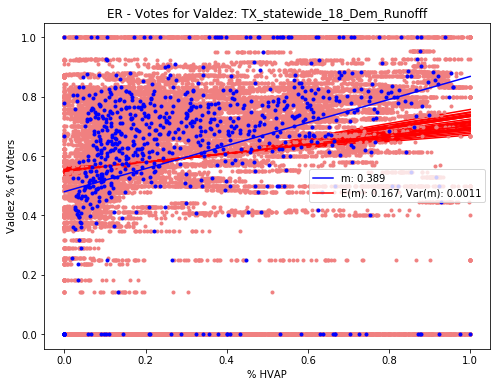

In [134]:
plot_er_graph(dallas_county_pcts, "Valdez", "HVAP", "TX_statewide_18_Dem_Runofff",
              "18R_Governor_D_tot", 0.25, "top_heavy", filt=False)
plt.show()

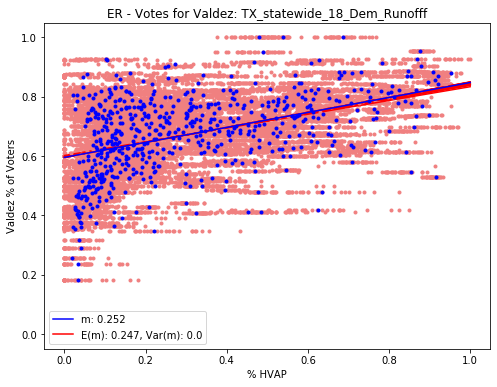

In [135]:
plot_er_graph(dallas_county_pcts, "Valdez", "HVAP", "TX_statewide_18_Dem_Runofff",
              "18R_Governor_D_tot", 0.25, "top_heavy", filt=True)
plt.show()

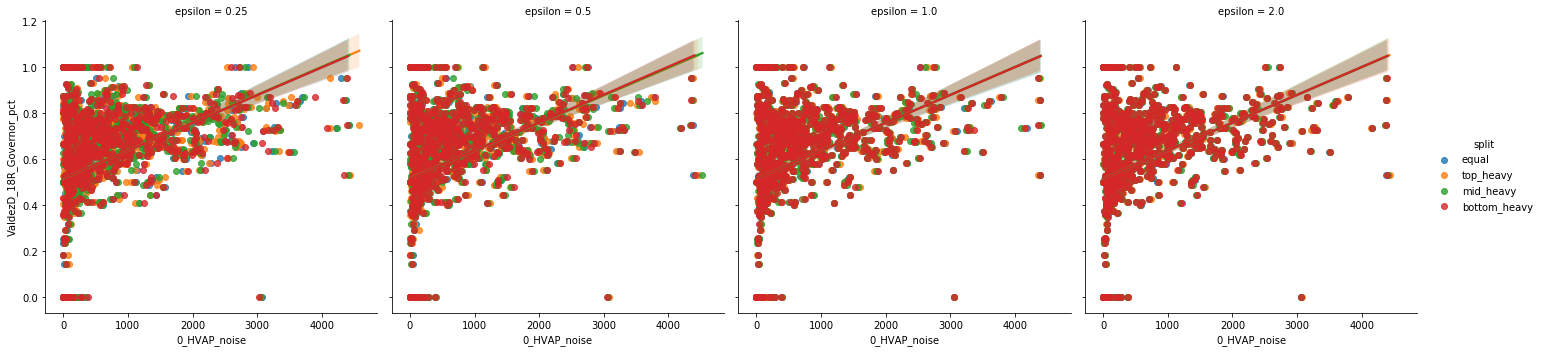

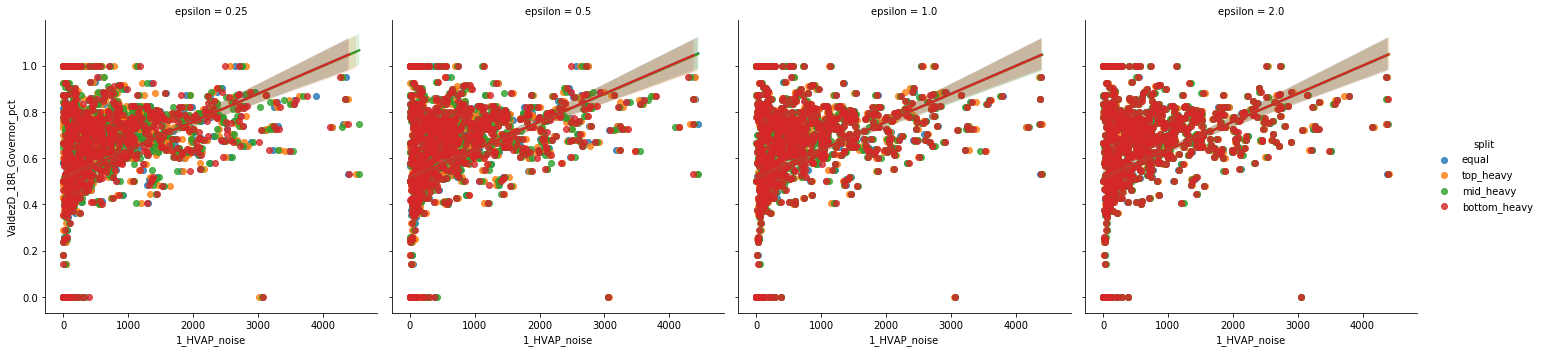

In [162]:
sns.lmplot(data=dallas_county_pcts, hue="split", col="epsilon", 
           x="0_HVAP_noise", y="ValdezD_18R_Governor_pct")
sns.lmplot(data=dallas_county_pcts, hue="split", col="epsilon", 
           x="1_HVAP_noise", y="ValdezD_18R_Governor_pct")

TypeError: inner() got multiple values for argument 'ax'

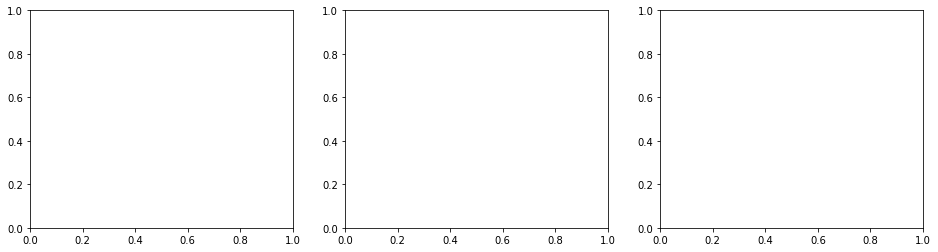

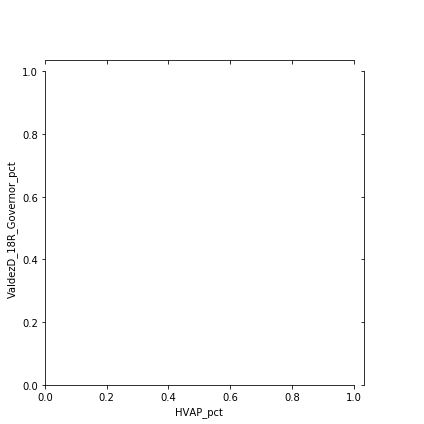

In [137]:
fig, axs = plt.subplots(1,3, figsize=(16,4))

sns.jointplot(data=dallas_county_pcts.query("`18R_Governor_D_tot` >= 10"), 
                x="HVAP_pct", y="ValdezD_18R_Governor_pct", ax=axs[0])

sns.jointplot(data=dallas_county_pcts.query("`18R_Governor_D_tot` >= 10"), 
                x="BVAP_pct", y="ValdezD_18R_Governor_pct", ax=axs[1])

sns.jointplot(data=dallas_county_pcts.query("`18R_Governor_D_tot` >= 10"), 
                x="WVAP_pct", y="ValdezD_18R_Governor_pct", ax=axs[2])

plt.show()

In [170]:
dallas_county_pcts["HVAP_pct"] - (dallas_county_pcts["0_HVAP_noise"] / dallas_county_pcts["0_VAP_noise"])

0        0.004223
1       -0.003346
2       -0.014692
3       -0.021913
4       -0.019563
           ...   
13227   -0.007874
13228   -0.003732
13229   -0.005096
13230   -0.000261
13231    0.004405
Length: 13232, dtype: float64

In [180]:
noised_hvap_perc = np.array([dallas_county_pcts["{}_HVAP_noise".format(i)] / dallas_county_pcts["{}_VAP_noise".format(i)] for i in range(32)])

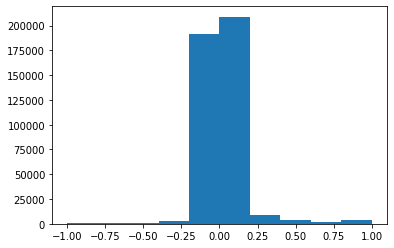

In [192]:
plt.hist(np.array([noised_hvap_perc[i] - dallas_county_pcts["HVAP_pct"] for i in range(32)]).flatten())
plt.show()

In [183]:
dallas_county_pcts["HVAP_pct"]

0        0.467443
1        0.467443
2        0.467443
3        0.467443
4        0.467443
           ...   
13227    0.101145
13228    0.101145
13229    0.101145
13230    0.101145
13231    0.101145
Name: HVAP_pct, Length: 13232, dtype: float64